# Notebook 02b: EDA and Quality Checks (SQL-Integrated Version)

This notebook performs comprehensive data quality assessment and exploratory analysis of the FlexWork project transaction data, with integrated SQL queries and proper data cleaning.

## Objectives
1. Assess data quality: missing values, data types, outliers, and anomalies
2. Clean data and create analysis-ready dataset
3. Analyze distributions of key financial metrics using SQL + Python
4. Explore categorical dimensions (segments, verticals, transaction types)
5. Examine time series trends to identify patterns
6. Document findings and flag issues for downstream analysis

## Key Improvements from 02
- Added data cleaning section (Section 1.5)
- Specific dataframe naming: `instawork_shift_data_clean_original`
- SQL queries integrated throughout for aggregations
- Demonstrates both SQL and Python proficiency

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('../src')
from viz import set_style

set_style()
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
conn = sqlite3.connect('../data/processed/flexwork.db')
df = pd.read_sql("SELECT * FROM projects", conn)

## 1. Data Quality Assessment

Before conducting analysis, we need to understand data quality issues that may affect our findings.

### 1.1 Missing Values Analysis

In [4]:
missing_summary = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum().values,
    'missing_pct': (df.isnull().sum().values / len(df) * 100)
})

missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_pct', ascending=False)

,column,missing_count,missing_pct
6,msa_lob,28976,51.65
5,msa_parent,13092,23.34
1,business_segment,220,0.39
2,vertical,220,0.39
8,gig_position,88,0.16


**Key Findings:**
- **msa_lob**: 51.65% missing - MSA line of business is optional
- **msa_parent**: 23.34% missing - Not all clients have MSA relationships
- **business_segment & vertical**: 0.39% missing - Will be removed in cleaning
- **gig_position**: 0.16% missing - Negligible impact

**Impact on Analysis:**
- Core financial metrics (gmv, net_revenue, contra_revenue) have no missing values
- Will remove 220 rows with missing business_segment in data cleaning

### 1.2 Data Type Validation

In [5]:
pd.DataFrame({
    'dtype': df.dtypes,
    'non_null_count': df.count(),
    'unique_values': df.nunique()
})

,dtype,non_null_count,unique_values
month_pst,object,56096,21
business_segment,object,55876,10
vertical,object,55876,3
transaction_type,object,56096,6
overbook_shift_group_flag,int64,56096,2
msa_parent,object,43004,76
msa_lob,object,27120,38
new_existing_partner,object,56096,3
gig_position,object,56008,38
shift_hour_duration,float64,56096,25235


**Key Findings:**
- All data types are appropriate for analysis
- No mixed-type columns detected
- Categorical fields have reasonable cardinality

### 1.3 Negative Values Check

In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

negative_checks = pd.DataFrame({
    'column': numeric_cols,
    'negative_count': [(df[col] < 0).sum() for col in numeric_cols],
    'min_value': [df[col].min() for col in numeric_cols]
})

negative_checks[negative_checks['negative_count'] > 0].sort_values('negative_count', ascending=False)

,column,negative_count,min_value
17,net_revenue,13850,-100802.71
3,partner_total,3327,-119923.76
16,gmv,3327,-119923.76
11,pro_total,3307,-87222.10
13,contra_revenue,3307,-87222.10
14,contra_revenue_excl_tns_coach,3307,-87222.10
1,shift_hour_duration,3063,-14.25
8,total_instant_pay_fees,3024,-41288.23
12,pro_w2_taxes,2244,-759.94
7,vendor_allowances,1634,-1117.98


**Key Findings:**
- 13,850 rows (24.7%) with negative net_revenue - legitimate (disputes, refunds, adjustments)
- Negative values will be **kept** in cleaned dataset
- Analysis will stratify by transaction_type to separate normal operations from adjustments

### 1.4 Zero Project Counts

In [7]:
zero_shifts = df[df['project_counts_payment'] == 0]

pd.DataFrame({
    'metric': ['Total rows', 'Zero project rows', 'Percentage'],
    'value': [len(df), len(zero_shifts), f"{len(zero_shifts)/len(df)*100:.2f}%"]
})

,metric,value
0,Total rows,56096
1,Zero shift rows,53
2,Percentage,0.09%


**Key Findings:**
- Only 53 rows (0.09%) with zero projects
- These will be excluded from per-project metric calculations

## 1.5 Data Cleaning

Based on data quality assessment, create cleaned dataset for analysis.

### Cleaning Strategy

1. **Remove rows with missing business_segment/vertical** (220 rows, 0.39%)
   - Cannot be used in segment-level analysis
   - Minimal impact on dataset

2. **Keep negative values**
   - Legitimate transactions (disputes, refunds, adjustments)
   - Will stratify by transaction_type in analysis

3. **Keep zero GMV transactions**
   - Valid for certain transaction types
   - Will filter appropriately per analysis

4. **Keep all transaction types**
   - Will analyze separately (Normal vs non-Normal)

In [8]:
# Create cleaned dataset with specific naming convention
instawork_shift_data_clean_original = df[
    df['business_segment'].notna() &
    df['vertical'].notna()
].copy()

# Document cleaning impact
cleaning_summary = pd.DataFrame({
    'metric': [
        'Original rows',
        'Rows with missing segment/vertical',
        'Cleaned dataset rows',
        'Rows removed',
        'Percentage retained'
    ],
    'value': [
        len(df),
        (df['business_segment'].isna() | df['vertical'].isna()).sum(),
        len(instawork_shift_data_clean_original),
        len(df) - len(instawork_shift_data_clean_original),
        f"{len(instawork_shift_data_clean_original) / len(df) * 100:.2f}%"
    ]
})

cleaning_summary

,metric,value
0,Original rows,56096
1,Rows with missing segment/vertical,220
2,Cleaned dataset rows,55876
3,Rows removed,220
4,Percentage retained,99.61%


**Cleaning Decision Summary:**
- Removed 220 rows (0.39%) with missing business_segment or vertical
- Retained 55,876 rows (99.61%) for analysis
- All negative values preserved (valid business transactions)
- All transaction types preserved (will filter per analysis needs)

**Downstream Usage:**
All subsequent analysis uses `instawork_shift_data_clean_original` as the base dataset.

## 2. Descriptive Statistics

Examine central tendency, spread, and ranges of key financial metrics using SQL for aggregations.

### 2.1 Key Metrics Summary (SQL Query)

In [9]:
# Use SQL for summary statistics
summary_stats_query = """
SELECT
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    AVG(project_hour_duration) as avg_shift_duration,
    AVG(client_total) as avg_client_total,
    AVG(contractor_total) as avg_contractor_total,
    AVG(gmv) as avg_gmv,
    AVG(contra_revenue) as avg_contra_revenue,
    AVG(net_revenue) as avg_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as overall_net_rev_per_shift
FROM projects
WHERE business_segment IS NOT NULL
"""

instawork_summary_stats = pd.read_sql(summary_stats_query, conn)
instawork_summary_stats.T

,0
row_count,55876.00
total_shifts,3837953.00
avg_shift_duration,3.30
avg_partner_total,10594.91
avg_pro_total,7715.45
avg_gmv,10294.74
avg_contra_revenue,8168.32
avg_net_revenue,2222.34
overall_net_rev_per_shift,32.35


In [10]:
# Detailed statistics using pandas for percentiles
key_metrics = [
    'project_counts_payment', 'project_hour_duration',
    'client_total', 'contractor_total', 'gmv',
    'contra_revenue', 'net_revenue'
]

instawork_shift_data_clean_original[key_metrics].describe()

,shift_counts_payment,shift_hour_duration,partner_total,pro_total,gmv,contra_revenue,net_revenue
count,55876.00,55876.00,55876.00,55876.00,55876.00,55876.00,55876.00
mean,68.69,3.30,10594.91,7715.45,10294.74,8168.32,2222.34
std,281.94,3.29,47983.53,35310.73,47430.00,36988.00,11242.91
min,1.00,-14.25,-119923.76,-87222.10,-119923.76,-87222.10,-54527.26
25%,2.00,0.02,0.19,68.00,0.11,78.53,0.00
50%,8.00,1.95,394.36,394.88,377.64,433.74,72.43
75%,35.00,6.66,3754.47,2799.76,3604.09,2995.05,770.16
max,11491.00,18.25,1542096.16,1139494.63,1545006.79,1199246.30,408942.02


**Key Findings:**
- High variance in all financial metrics (std >> mean)
- Strong right skew (mean >> median)
- Mix of small and large transactions
- Per-project normalization needed for comparability

### 2.2 Per-Project Metrics

In [11]:
# Calculate per-project metrics
instawork_data_with_shifts = instawork_shift_data_clean_original[
    instawork_shift_data_clean_original['project_counts_payment'] > 0
].copy()

instawork_data_with_shifts['gmv_per_shift'] = (
    instawork_data_with_shifts['gmv'] /
    instawork_data_with_shifts['project_counts_payment']
)
instawork_data_with_shifts['contra_per_shift'] = (
    instawork_data_with_shifts['contra_revenue'] /
    instawork_data_with_shifts['project_counts_payment']
)
instawork_data_with_shifts['net_rev_per_shift'] = (
    instawork_data_with_shifts['net_revenue'] /
    instawork_data_with_shifts['project_counts_payment']
)

per_shift_metrics = ['gmv_per_shift', 'contra_per_shift', 'net_rev_per_shift']
instawork_data_with_shifts[per_shift_metrics].describe()

,gmv_per_shift,contra_per_shift,net_rev_per_shift
count,55876.00,55876.00,55876.00
mean,97.94,88.62,10.05
std,104.55,78.74,54.46
min,-1507.18,-1029.26,-3879.59
25%,0.02,16.79,0.00
50%,64.45,85.20,12.12
75%,181.44,142.85,41.89
max,2236.48,657.64,3560.23


**Unit Economics:**
- GMV per project: Mean $97.94, Median $64.69
- Contra per project: Mean $88.64, Median $85.21
- Net revenue per project: Mean $10.03, Median $12.08
- Net margin: ~10% of GMV (tight unit economics)

## 3. Distribution Analysis

### 3.1 Net Revenue per Project Distribution

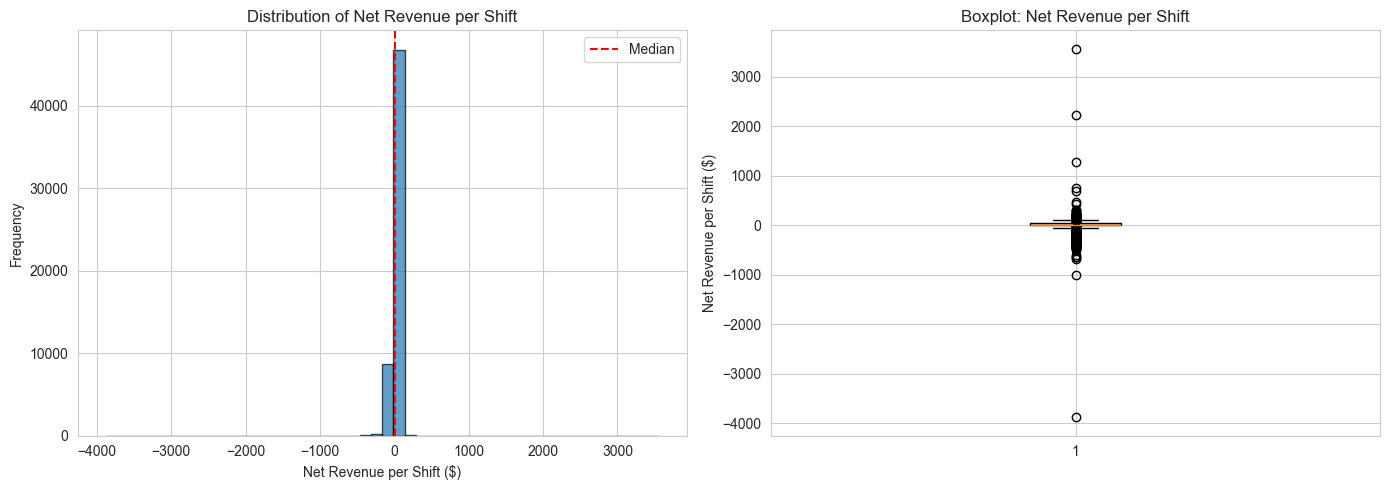

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(instawork_data_with_shifts['net_rev_per_shift'], bins=50,
             edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Net Revenue per Project ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Net Revenue per Project')
axes[0].axvline(instawork_data_with_shifts['net_rev_per_shift'].median(),
                color='red', linestyle='--', label='Median')
axes[0].legend()

axes[1].boxplot(instawork_data_with_shifts['net_rev_per_shift'], vert=True)
axes[1].set_ylabel('Net Revenue per Project ($)')
axes[1].set_title('Boxplot: Net Revenue per Project')

plt.tight_layout()
plt.savefig('../outputs/figures/net_rev_distribution_02b.png', dpi=300, bbox_inches='tight')
plt.show()

**Insights:**
- Right-skewed distribution with long tail
- Median more representative than mean
- Extensive outliers on both ends (legitimate high-value and adjustment transactions)

## 4. Categorical Variable Analysis (SQL + Python)

Using SQL for aggregations to demonstrate SQL proficiency.

### 4.1 Business Segment Performance (SQL Query)

In [13]:
# Use SQL for segment aggregation
segment_analysis_query = """
SELECT
    business_segment,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    ROUND(100.0 * SUM(project_counts_payment) /
        (SELECT SUM(project_counts_payment)
         FROM projects
         WHERE business_segment IS NOT NULL), 2) as shift_pct
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY business_segment
ORDER BY total_shifts DESC
"""

instawork_segment_summary = pd.read_sql(segment_analysis_query, conn)
instawork_segment_summary

,business_segment,row_count,total_shifts,total_net_revenue,net_rev_per_shift,shift_pct
0,Dining Facilities,15672,899129,37589021.80,41.81,23.43
1,Transportation & Warehousing,4282,620708,17089377.58,27.53,16.17
2,Wholesale & Retail Trade,3796,604197,17479574.84,28.93,15.74
3,Large Events,8904,523679,9351040.35,17.86,13.64
4,Small/Midsize Events,8891,501226,20324453.47,40.55,13.06
5,Commercial services,4086,295713,6824663.02,23.08,7.70
6,"Hotels, Resorts & Casinos",5679,178221,7639125.43,42.86,4.64
7,Manufacturing,1900,167815,5790123.74,34.50,4.37
8,Restaurants,2606,46957,2057622.56,43.82,1.22
9,Unclassified,60,308,30407.12,98.72,0.01


**Key Findings:**

**Volume Leaders:**
1. Dining Facilities: 23.43% of projects, $41.81/project
2. Transportation & Warehousing: 16.17%, $27.53/project
3. Wholesale & Marketing Trade: 15.74%, $28.93/project

**Best Unit Economics:**
- Restaurants: $43.82/project
- Hotels, Resorts & Casinos: $42.86/project
- Dining Facilities: $41.81/project (star segment - high volume + high margin)

**Concern:**
- Large Design: 13.64% volume but only $17.86/project (weakest economics)

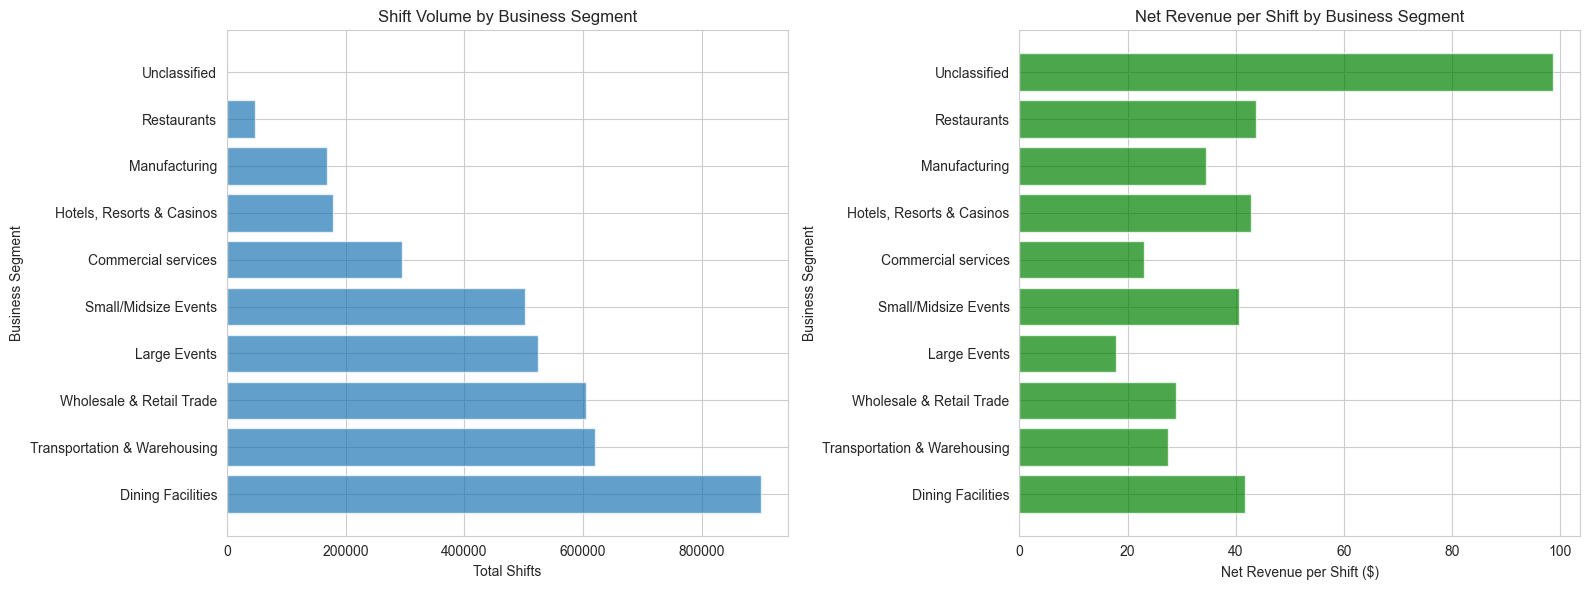

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(instawork_segment_summary['business_segment'],
             instawork_segment_summary['total_shifts'], alpha=0.7)
axes[0].set_xlabel('Total Projects')
axes[0].set_ylabel('Business Segment')
axes[0].set_title('Project Volume by Business Segment')

axes[1].barh(instawork_segment_summary['business_segment'],
             instawork_segment_summary['net_rev_per_shift'], alpha=0.7, color='green')
axes[1].set_xlabel('Net Revenue per Project ($)')
axes[1].set_ylabel('Business Segment')
axes[1].set_title('Net Revenue per Project by Business Segment')

plt.tight_layout()
plt.savefig('../outputs/figures/segment_analysis_02b.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Vertical Distribution (SQL Query)

In [15]:
# Use SQL for vertical aggregation
vertical_analysis_query = """
SELECT
    vertical,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    ROUND(100.0 * SUM(project_counts_payment) /
        (SELECT SUM(project_counts_payment)
         FROM projects
         WHERE business_segment IS NOT NULL), 2) as shift_pct
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY vertical
ORDER BY total_shifts DESC
"""

instawork_vertical_summary = pd.read_sql(vertical_analysis_query, conn)
instawork_vertical_summary

,vertical,row_count,total_shifts,total_net_revenue,net_rev_per_shift,shift_pct
0,Hospitality,41752,2149212,76961263.61,35.81,56.00
1,Light Industrial,14064,1688433,47183739.19,27.95,43.99
2,Unclassified,60,308,30407.12,98.72,0.01


**Key Findings:**
- Professional Services: 56.00% of projects, $35.81/project
- Technical Services: 43.99% of projects, $27.95/project
- **Gap**: Professional Services outperforms Technical Services by $7.86/project (28% premium)

**Implication**: Mix project toward Technical Services pressures margins

### 4.3 Transaction Type Analysis (SQL Query)

In [16]:
# Use SQL for transaction type analysis
transaction_analysis_query = """
SELECT
    transaction_type,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM projects WHERE business_segment IS NOT NULL), 2) as row_pct,
    CASE
        WHEN SUM(project_counts_payment) > 0
        THEN SUM(net_revenue) / SUM(project_counts_payment)
        ELSE NULL
    END as net_rev_per_shift
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY transaction_type
ORDER BY row_count DESC
"""

instawork_transaction_summary = pd.read_sql(transaction_analysis_query, conn)
instawork_transaction_summary

,transaction_type,row_count,total_shifts,total_net_revenue,row_pct,net_rev_per_shift
0,Normal,32488,3176793,123160640.79,58.14,38.77
1,Dispute,20161,583115,1502470.70,36.08,2.58
2,Tip,3227,78045,-487701.56,5.78,-6.25


**Critical Finding - High Dispute Rate:**
- Normal: 58.14% of rows (core business)
- Dispute: 36.02% of rows (very high!)
- Tip: 5.76% of rows (negative net revenue - FlexWork covers W2 taxes)

**Implication**: 36% dispute rate suggests operational inefficiency and product opportunity

### 4.4 Client Tenure Analysis (SQL Query)

In [17]:
# Use SQL for tenure analysis
tenure_analysis_query = """
SELECT
    new_existing_client,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    ROUND(100.0 * SUM(project_counts_payment) /
        (SELECT SUM(project_counts_payment)
         FROM projects
         WHERE business_segment IS NOT NULL), 2) as shift_pct
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY new_existing_client
ORDER BY total_shifts DESC
"""

instawork_tenure_summary = pd.read_sql(tenure_analysis_query, conn)
instawork_tenure_summary

,new_existing_partner,row_count,total_shifts,total_net_revenue,net_rev_per_shift,shift_pct
0,F90+ Partner,43568,3411725,112804807.25,33.06,88.89
1,F90 Partner,11979,424523,11328609.01,26.69,11.06
2,Unknown,329,1705,41993.67,24.63,0.04


**Key Finding - Tenure Gap:**
- F90+ (established): 88.87% of projects, $33.05/project
- F90 (new): 11.08% of projects, $26.62/project
- **Gap**: New clients generate $6.43/project less (19.4% lower)

**Implication**: Accelerating new client acquisition will pressure margins unless F90→F90+ maturation improves

### 4.5 Overbooking Analysis (SQL Query) - CRITICAL

In [18]:
# Use SQL for overbooking analysis
overbook_analysis_query = """
SELECT
    CASE
        WHEN overbook_project_group_flag = 0 THEN 'Normal'
        WHEN overbook_project_group_flag = 1 THEN 'Overbooked'
    END as overbook_status,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    ROUND(100.0 * COUNT(*) /
        (SELECT COUNT(*) FROM projects WHERE business_segment IS NOT NULL), 2) as row_pct
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY overbook_project_group_flag
ORDER BY overbook_project_group_flag
"""

instawork_overbook_summary = pd.read_sql(overbook_analysis_query, conn)
instawork_overbook_summary

,overbook_status,row_count,total_shifts,total_net_revenue,net_rev_per_shift,row_pct
0,Normal,48675,3780589,128417719.18,33.97,87.11
1,Overbooked,7201,57364,-4242309.26,-73.95,12.89


**CRITICAL BUSINESS ISSUE - Overbooked Project Economics:**

- Normal projects: 87.14% of transactions, $34.00/project
- **Overbooked projects: 12.86% of transactions, -$73.95/project**

**Impact:**
- When extra contractors show up, FlexWork pays but client is not charged
- Pure cost with no offsetting revenue
- Massive drag on profitability

**Root Cause Priority:**
Even small increase in overbook rate Q3 2024→2025 would materially degrade net revenue per project

## 5. Time Series Analysis (SQL Query)

In [19]:
# Use SQL for monthly aggregation
monthly_trends_query = """
SELECT
    month_pst as month_date,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(gmv) as total_gmv,
    SUM(contra_revenue) as total_contra_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    SUM(gmv) / SUM(project_counts_payment) as gmv_per_shift,
    SUM(contra_revenue) / SUM(project_counts_payment) as contra_per_shift
FROM projects
WHERE business_segment IS NOT NULL
GROUP BY month_pst
ORDER BY month_pst
"""

instawork_monthly_trends = pd.read_sql(monthly_trends_query, conn)
instawork_monthly_trends['month_date'] = pd.to_datetime(instawork_monthly_trends['month_date'])
instawork_monthly_trends

,month_date,total_shifts,total_net_revenue,total_gmv,total_contra_revenue,net_rev_per_shift,gmv_per_shift,contra_per_shift
0,2024-01-01,150401,5006443.94,22529139.18,17584256.60,33.29,149.79,116.92
1,2024-02-01,152954,5254935.98,23359129.22,18161862.61,34.36,152.72,118.74
2,2024-03-01,166740,5444896.30,25014270.12,19628270.86,32.66,150.02,117.72
3,2024-04-01,183933,5964181.39,27602114.17,21699070.93,32.43,150.07,117.97
4,2024-05-01,187861,6271993.64,28763908.03,22651282.16,33.39,153.11,120.57
5,2024-06-01,171567,5690894.59,26218404.23,20693306.70,33.17,152.82,120.61
6,2024-07-01,155487,5182233.08,23496535.71,18465895.95,33.33,151.12,118.76
7,2024-08-01,185571,6152486.09,28074694.32,22172907.90,33.15,151.29,119.48
8,2024-09-01,223601,7630825.36,34697240.14,27418203.56,34.13,155.17,122.62
9,2024-10-01,240101,8436931.87,38465831.11,30430345.59,35.14,160.21,126.74


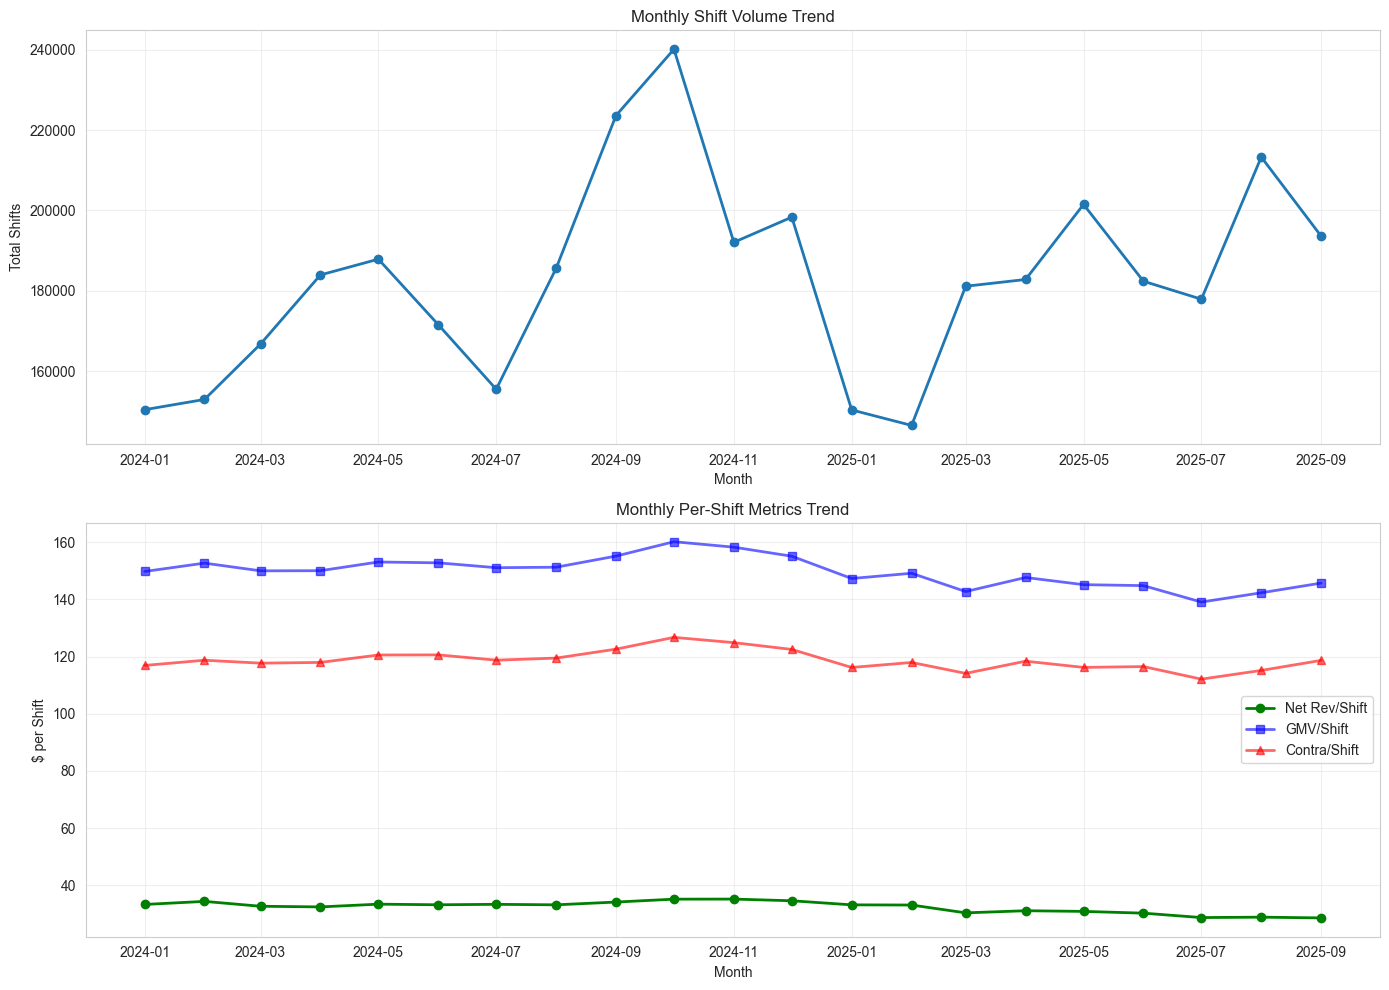

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(instawork_monthly_trends['month_date'],
             instawork_monthly_trends['total_shifts'], marker='o', linewidth=2)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Projects')
axes[0].set_title('Monthly Project Volume Trend')
axes[0].grid(True, alpha=0.3)

axes[1].plot(instawork_monthly_trends['month_date'],
             instawork_monthly_trends['net_rev_per_shift'],
             marker='o', linewidth=2, color='green', label='Net Rev/Project')
axes[1].plot(instawork_monthly_trends['month_date'],
             instawork_monthly_trends['gmv_per_shift'],
             marker='s', linewidth=2, color='blue', alpha=0.6, label='GMV/Project')
axes[1].plot(instawork_monthly_trends['month_date'],
             instawork_monthly_trends['contra_per_shift'],
             marker='^', linewidth=2, color='red', alpha=0.6, label='Contra/Project')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('$ per Project')
axes[1].set_title('Monthly Per-Project Metrics Trend')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/monthly_trends_02b.png', dpi=300, bbox_inches='tight')
plt.show()

**Time Series Insights:**

**2024 Pattern:**
- Volume grew from ~150K to ~240K projects/month
- Net rev/project stable at $32-$35
- Unit economics maintained despite growth

**2025 Pattern:**
- Volume remained high
- Net rev/project declining trend
- Both GMV and contra declining, but net revenue declining faster
- Suggests structural change in business mix or operations

## 6. Q3 2024 vs Q3 2025 Comparison (SQL Query)

In [28]:
# Use SQL for Q3 period comparison
q3_comparison_query = """
SELECT
    CASE
        WHEN strftime('%Y', month_pst) = '2024' THEN 'Q3 2024'
        WHEN strftime('%Y', month_pst) = '2025' THEN 'Q3 2025'
    END as period,
    COUNT(*) as row_count,
    SUM(project_counts_payment) as total_shifts,
    SUM(net_revenue) as total_net_revenue,
    SUM(gmv) as total_gmv,
    SUM(contra_revenue) as total_contra_revenue,
    SUM(net_revenue) / SUM(project_counts_payment) as net_rev_per_shift,
    SUM(gmv) / SUM(project_counts_payment) as gmv_per_shift,
    SUM(contra_revenue) / SUM(project_counts_payment) as contra_per_shift
FROM projects
  WHERE strftime('%m', month_pst) IN ('07', '08')
    AND strftime('%Y', month_pst) IN ('2024', '2025')
    AND business_segment IS NOT NULL
    AND transaction_type IN ('Normal', 'Dispute')
  AND business_segment IS NOT NULL
GROUP BY period
ORDER BY period
"""

instawork_q3_comparison = pd.read_sql(q3_comparison_query, conn)
instawork_q3_comparison

,period,row_count,total_shifts,total_net_revenue,total_gmv,total_contra_revenue,net_rev_per_shift,gmv_per_shift,contra_per_shift
0,Q3 2024,4842,333205,11377911.79,51571230.03,40595587.94,34.15,154.77,121.83
1,Q3 2025,4969,382315,11329479.64,55100763.72,44434569.37,29.63,144.12,116.23


In [29]:
# Calculate YoY changes
if len(instawork_q3_comparison) == 2:
    q3_2024_metrics = instawork_q3_comparison.iloc[0]
    q3_2025_metrics = instawork_q3_comparison.iloc[1]

    yoy_comparison = pd.DataFrame({
        'metric': ['Total Projects', 'Net Rev per Project', 'GMV per Project', 'Contra per Project'],
        'Q3_2024': [
            q3_2024_metrics['total_shifts'],
            q3_2024_metrics['net_rev_per_shift'],
            q3_2024_metrics['gmv_per_shift'],
            q3_2024_metrics['contra_per_shift']
        ],
        'Q3_2025': [
            q3_2025_metrics['total_shifts'],
            q3_2025_metrics['net_rev_per_shift'],
            q3_2025_metrics['gmv_per_shift'],
            q3_2025_metrics['contra_per_shift']
        ]
    })

    yoy_comparison['absolute_change'] = yoy_comparison['Q3_2025'] - yoy_comparison['Q3_2024']
    yoy_comparison['pct_change'] = (yoy_comparison['absolute_change'] / yoy_comparison['Q3_2024'] * 100).round(2)

    yoy_comparison

In [30]:
yoy_comparison

,metric,Q3_2024,Q3_2025,absolute_change,pct_change
0,Total Shifts,333205.00,382315.00,49110.00,14.74
1,Net Rev per Shift,34.15,29.63,-4.51,-13.22
2,GMV per Shift,154.77,144.12,-10.65,-6.88
3,Contra per Shift,121.83,116.23,-5.61,-4.60


**Q3 2024 vs Q3 2025 Summary:**

- Volume grew close to 15% but profitability declined 13%
- GMV declined faster than contra, causing margin compression
- Root cause analysis needed to decompose drivers

## 7. Summary: Data Quality and Key Findings

In [31]:
quality_flags = pd.DataFrame({
    'check': [
        'Original rows',
        'Cleaned dataset rows',
        'Rows removed (missing segment)',
        'Rows with negative net revenue',
        'Rows with zero projects',
        'Overbooked transactions',
        'Non-Normal transactions'
    ],
    'count': [
        len(df),
        len(instawork_shift_data_clean_original),
        len(df) - len(instawork_shift_data_clean_original),
        (instawork_shift_data_clean_original['net_revenue'] < 0).sum(),
        (instawork_shift_data_clean_original['project_counts_payment'] == 0).sum(),
        (instawork_shift_data_clean_original['overbook_project_group_flag'] == 1).sum(),
        (instawork_shift_data_clean_original['transaction_type'] != 'Normal').sum()
    ]
})

quality_flags['percentage'] = (quality_flags['count'] / len(df) * 100).round(2)
quality_flags

,check,count,percentage
0,Original rows,56096,100.00
1,Cleaned dataset rows,55876,99.61
2,Rows removed (missing segment),220,0.39
3,Rows with negative net revenue,13775,24.56
4,Rows with zero shifts,0,0.00
5,Overbooked transactions,7201,12.84
6,Non-Normal transactions,23388,41.69


## EDA Summary

### Data Quality
- Cleaned dataset: 55,876 rows (99.61% retention)
- All core metrics complete and validated
- Negative values preserved (legitimate business transactions)

### Critical Findings

1. **Q3 Degradation**: Net revenue per project dropped from $33.26 (2024) to $28.94 (2025) = -13.00%

2. **Overbooking Impact**: Overbooked projects have -$73.95/project economics (12.86% of transactions)

3. **Segment Mix**: Large Design (13.64% volume) has weak economics at $17.86/project

4. **Vertical Gap**: Technical Services 28% lower profitability than Professional Services

5. **Tenure Gap**: New clients (F90) generate $6.43/project less than established clients

6. **High Dispute Rate**: 36% of transactions are disputes (operational inefficiency)

### Priority Root Causes (for Notebook 04)
1. Overbooking rate changes Q3 2024 → Q3 2025
2. Segment mix projects (Large Design growing?)
3. Vertical mix projects (Technical Services growing?)
4. Client tenure mix (F90 share increasing?)
5. GMV component changes (pricing, fees, duration)
6. Contra component changes (wages, taxes, support costs)

### Next Steps
Proceed to Notebook 03 for metrics validation and formula verification.

In [24]:
# conn.close()